In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from daugman import find_iris

## Demo

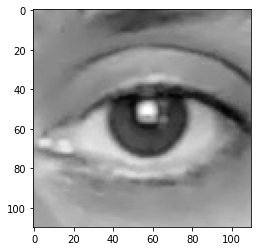

In [2]:
# read, square crop and grayscale image of an eye
img = cv2.imread('eye.jpg')
img = img[20:130, 20:130]
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_ = plt.imshow(gray_img, cmap='gray')

In [3]:
# find iris
minimal_iris_radius = 10
answer = find_iris(gray_img, minimal_iris_radius)
print(answer)

iris_center, iris_rad = answer

((57, 54), 20)


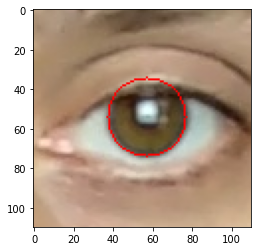

In [4]:
# plot result
out = img.copy()
cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)
_ = plt.imshow(out[::,::,::-1])

## Speed measurement

In [5]:
%%timeit
find_iris(gray_img, minimal_iris_radius)
# ON SERVER: 56.3 ms ± 383 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
# ON NOTEBOOK: 330 ms ± 3.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# it is 70-90 time faster than https://github.com/Fejcvk/Iris-Comparator/blob/master/daugman.py

81.7 ms ± 4.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
import cProfile
# function profiling
cProfile.run('find_iris(gray_img, minimal_iris_radius)')

         21638 function calls (21300 primitive calls) in 0.106 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      169    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(argmax)
      169    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(copyto)
      169    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(empty_like)
      169    0.000    0.000    0.002    0.000 <__array_function__ internals>:2(zeros_like)
        1    0.000    0.000    0.106    0.106 <string>:1(<module>)
        1    0.000    0.000    0.106    0.106 daugman.py:56(find_iris)
      169    0.072    0.000    0.105    0.001 daugman.py:8(daugman)
      169    0.000    0.000    0.000    0.000 fromnumeric.py:1110(_argmax_dispatcher)
      169    0.000    0.000    0.001    0.000 fromnumeric.py:1114(argmax)
      169    0.000    0.000    0.001    0.000 fromnumeric.py:52(_wrapfunc)
      169    0.000    0.000  